# Advanced MICE Parameters

This notebook demonstrates advanced parameter settings and customization options in MICE.

## Overview

In this notebook, we will explore:
1. Method-specific parameters (e.g., PMM donors, CART depth)
2. Predictor matrix control (auto-generated vs custom)
3. Imputation control parameters (n_imputations, maxit, visit_sequence)
4. Initial imputation methods
5. Convergence assessment with different settings


## 1. Import Libraries and Load Data


In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from imputation.MICE import MICE
from plotting.diagnostics import stripplot, plot_chain_stats

# Load NHANES dataset
df = pd.read_csv('data/nhanes.csv')
print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())


Dataset shape: (25, 4)

Missing values:
age     0
bmi     9
hyp     8
chl    10
dtype: int64


## 2. Method-Specific Parameters

Different imputation methods accept specific parameters to control their behavior.


### 2.1 PMM with Different Donor Counts

PMM accepts a `donors` parameter that controls how many donor observations are considered.


In [2]:
# PMM with 3 donors (default is 5)
mice_pmm_3 = MICE(df)
mice_pmm_3.impute(n_imputations=5, maxit=10, method='pmm', pmm_donors=3)

print("Imputation with PMM (3 donors) complete!")

# PMM with 10 donors
mice_pmm_10 = MICE(df)
mice_pmm_10.impute(n_imputations=5, maxit=10, method='pmm', pmm_donors=10)

print("Imputation with PMM (10 donors) complete!")


Imputation with PMM (3 donors) complete!
Imputation with PMM (10 donors) complete!


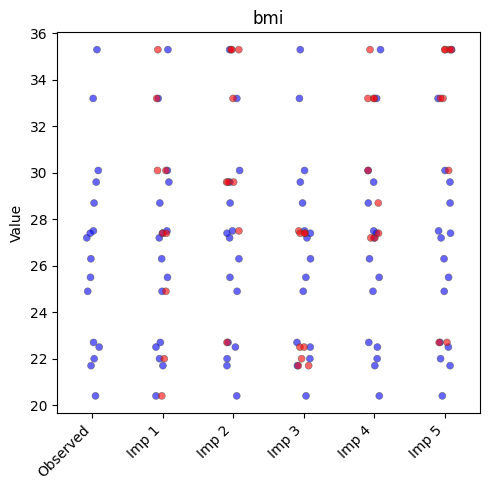

In [3]:
# Compare results visually
missing_pattern = df.notna().astype(int)
stripplot(mice_pmm_3.imputed_datasets, missing_pattern, columns=['bmi'])


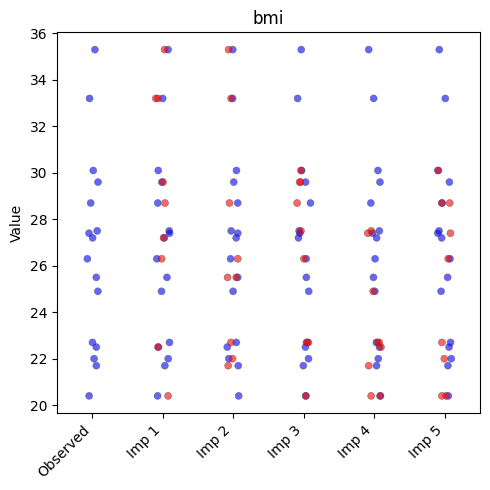

In [4]:
stripplot(mice_pmm_10.imputed_datasets, missing_pattern, columns=['bmi'])


### 2.2 Passing Multiple Method-Specific Parameters

You can pass parameters for multiple methods at once using the prefix convention.


In [5]:
# Use different methods with their specific parameters
# Format: methodname_parametername=value
method_dict = {
    'age': 'sample',
    'bmi': 'pmm',
    'hyp': 'cart',
    'chl': 'rf'
}

mice_custom = MICE(df)
mice_custom.impute(
    n_imputations=5,
    maxit=10,
    method=method_dict,
    pmm_donors=7,           # Parameter for PMM
    cart_max_depth=5,       # Parameter for CART
    rf_n_estimators=50      # Parameter for Random Forest
)

print("Imputation with custom parameters complete!")
print(f"Methods used: {mice_custom.method}")


Imputation with custom parameters complete!
Methods used: {'age': 'sample', 'bmi': 'pmm', 'hyp': 'cart', 'chl': 'rf'}


## 3. Predictor Matrix Control

The predictor matrix determines which variables are used to predict each target variable.


### 3.1 Auto-generated Predictor Matrix with _quickpred

By default, MICE uses `_quickpred` to automatically generate a predictor matrix based on correlations.


In [6]:
# Default predictor matrix (min_cor=0.1, min_puc=0.0)
mice_default = MICE(df)
mice_default.impute(n_imputations=5, maxit=10, method='pmm')

print("Default predictor matrix:")
print(mice_default.predictor_matrix)


Default predictor matrix:
     age  bmi  hyp  chl
age    0    0    0    0
bmi    1    0    0    1
hyp    1    0    0    1
chl    1    1    1    0


In [7]:
# Higher correlation threshold (more selective)
mice_selective = MICE(df)
mice_selective.impute(
    n_imputations=5,
    maxit=10,
    method='pmm',
    min_cor=0.3,  # Only use predictors with |correlation| >= 0.3
    min_puc=0.5   # Require at least 50% usable cases
)

print("\nSelective predictor matrix (min_cor=0.3):")
print(mice_selective.predictor_matrix)



Selective predictor matrix (min_cor=0.3):
     age  bmi  hyp  chl
age    0    0    0    0
bmi    1    0    0    1
hyp    1    0    0    1
chl    1    1    1    0


### 3.2 Custom Predictor Matrix

You can specify exactly which variables should predict which.


In [8]:
# Create a custom predictor matrix
# Rows = target variables, Columns = predictor variables
# 1 = use as predictor, 0 = don't use

cols = df.columns
custom_pred_matrix = pd.DataFrame(0, index=cols, columns=cols)

# Example: Only use 'age' to predict everything
custom_pred_matrix.loc['bmi', 'age'] = 1
custom_pred_matrix.loc['hyp', 'age'] = 1
custom_pred_matrix.loc['chl', 'age'] = 1

# Use 'bmi' and 'age' to predict 'chl'
custom_pred_matrix.loc['chl', 'bmi'] = 1

print("Custom predictor matrix:")
print(custom_pred_matrix)

mice_custom_pred = MICE(df)
mice_custom_pred.impute(
    n_imputations=5,
    maxit=10,
    method='pmm',
    predictor_matrix=custom_pred_matrix
)

print("\nImputation with custom predictor matrix complete!")


Custom predictor matrix:
     age  bmi  hyp  chl
age    0    0    0    0
bmi    1    0    0    0
hyp    1    0    0    0
chl    1    1    0    0

Imputation with custom predictor matrix complete!


/Users/zhannalopuliak/Documents/mice-py/examples/../imputation/validators.py:247: UserWarning: Target variables without missing data are being imputed: ['age']. This is unnecessary but allowed.
  warnings.warn(f"Target variables without missing data are being imputed: {complete_targets}. This is unnecessary but allowed.")


### 3.3 Include/Exclude Specific Predictors

You can force inclusion or exclusion of specific predictors.


In [9]:
# Always include 'age' as a predictor, exclude 'hyp'
mice_include_exclude = MICE(df)
mice_include_exclude.impute(
    n_imputations=5,
    maxit=10,
    method='pmm',
    include=['age'],  # Always use age as a predictor
    exclude=['hyp']   # Never use hyp as a predictor
)

print("Predictor matrix with include/exclude:")
print(mice_include_exclude.predictor_matrix)


Predictor matrix with include/exclude:
     age  bmi  hyp  chl
age    0    0    0    0
bmi    1    0    0    1
hyp    1    0    0    1
chl    1    1    0    0


## 4. Imputation Control Parameters

Control the number of imputations, iterations, and visit sequence.


### 4.1 Number of Imputations (n_imputations)

More imputations generally provide more stable results but take longer.


In [10]:
# Few imputations (faster)
mice_5 = MICE(df)
mice_5.impute(n_imputations=5, maxit=10, method='pmm')
print(f"Generated {len(mice_5.imputed_datasets)} imputed datasets")

# More imputations (more stable)
mice_20 = MICE(df)
mice_20.impute(n_imputations=20, maxit=10, method='pmm')
print(f"Generated {len(mice_20.imputed_datasets)} imputed datasets")


Generated 5 imputed datasets
Generated 20 imputed datasets


### 4.2 Maximum Iterations (maxit)

More iterations allow the algorithm more time to converge.


In [11]:
# Few iterations
mice_5iter = MICE(df)
mice_5iter.impute(n_imputations=5, maxit=5, method='pmm')

# More iterations
mice_20iter = MICE(df)
mice_20iter.impute(n_imputations=5, maxit=20, method='pmm')

print("Comparing convergence with different iterations:")


Comparing convergence with different iterations:


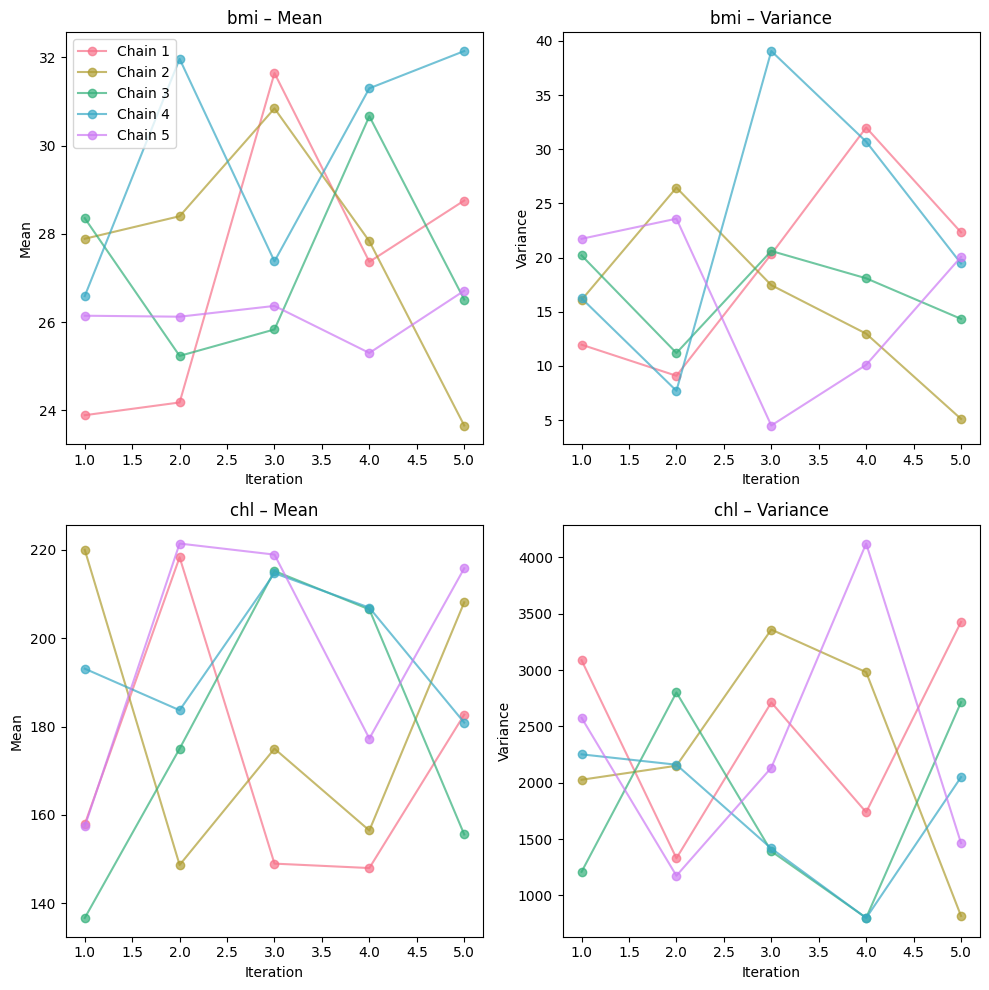

In [12]:
# Plot convergence with 5 iterations
plot_chain_stats(mice_5iter.chain_mean, mice_5iter.chain_var, columns=['bmi', 'chl'])


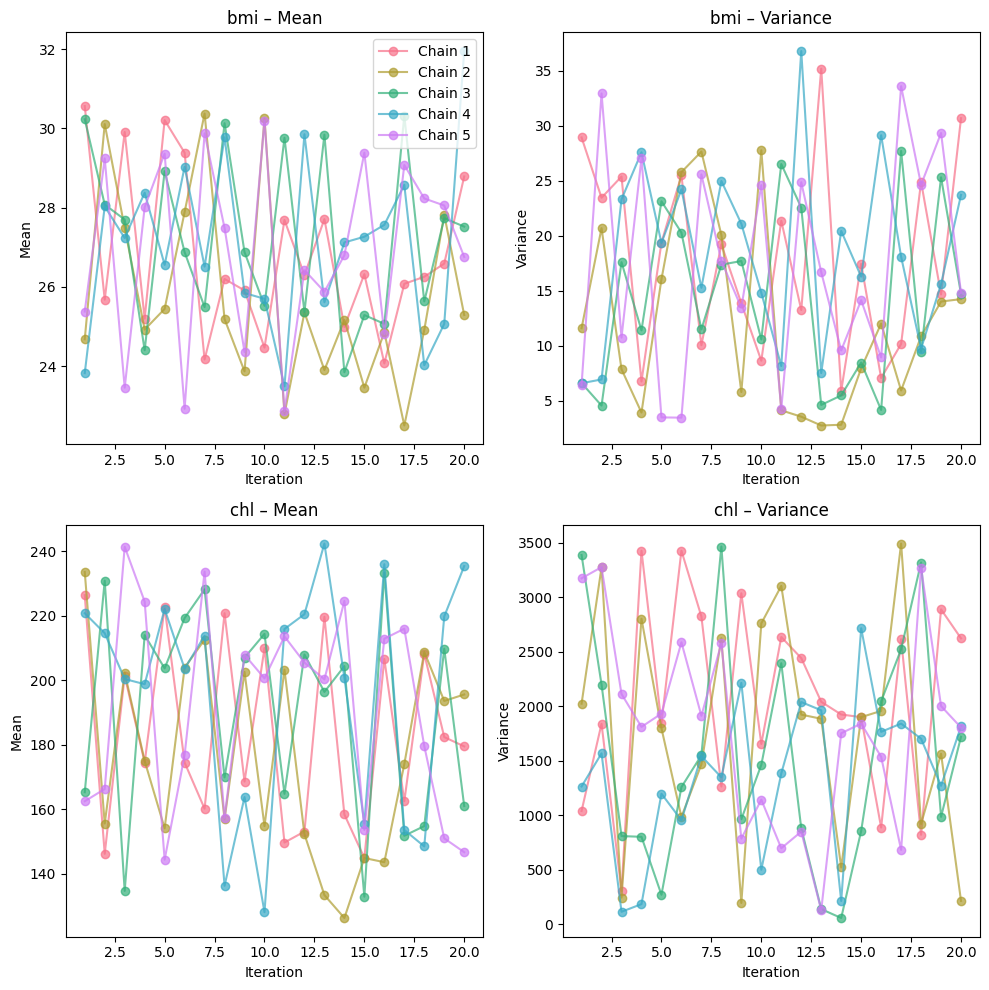

In [13]:
# Plot convergence with 20 iterations
plot_chain_stats(mice_20iter.chain_mean, mice_20iter.chain_var, columns=['bmi', 'chl'])


### 4.3 Visit Sequence

The visit sequence determines the order in which variables are imputed.


In [18]:
# Monotone sequence (default) - least missing to most missing
mice_monotone = MICE(df)
mice_monotone.impute(n_imputations=5, maxit=10, method='pmm', visit_sequence='monotone')
print(f"Monotone visit sequence: {mice_monotone.visit_sequence}")

# Custom sequence
custom_sequence = ['chl', 'bmi', 'hyp']  # Specify exact order
mice_custom_seq = MICE(df)
mice_custom_seq.impute(n_imputations=5, maxit=10, method='pmm', visit_sequence=custom_sequence)
print(f"Custom visit sequence: {mice_custom_seq.visit_sequence}")


Monotone visit sequence: ['hyp', 'bmi', 'chl']
Custom visit sequence: ['chl', 'bmi', 'hyp']


## 5. Initial Imputation Methods

The initial imputation sets the starting values before the iterative process begins.


In [19]:
# Sample initial method (default) - random sampling from observed values
mice_sample_init = MICE(df)
mice_sample_init.impute(n_imputations=5, maxit=10, method='pmm', initial='sample')
print("Using 'sample' initial method")

# Meanobs initial method - use observed value closest to the mean
mice_meanobs_init = MICE(df)
mice_meanobs_init.impute(n_imputations=5, maxit=10, method='pmm', initial='meanobs')
print("Using 'meanobs' initial method")


Using 'sample' initial method
Using 'meanobs' initial method


## 6. Putting It All Together

Let's combine multiple advanced parameters in a single imputation.


In [20]:
# Comprehensive example with multiple advanced parameters
method_dict = {
    'age': 'sample',
    'bmi': 'pmm',
    'hyp': 'cart',
    'chl': 'rf'
}

mice_comprehensive = MICE(df)
mice_comprehensive.impute(
    n_imputations=10,                    # More imputations for stability
    maxit=15,                            # More iterations for convergence
    method=method_dict,                  # Different methods per column
    pmm_donors=7,                        # PMM-specific parameter
    cart_max_depth=5,                    # CART-specific parameter
    rf_n_estimators=50,                  # RF-specific parameter
    min_cor=0.2,                         # Predictor matrix control
    min_puc=0.3,                         # Minimum usable cases
    visit_sequence=['bmi', 'hyp', 'chl'], # Custom visit order
    initial='meanobs'                    # Initial imputation method
)

print("Comprehensive imputation complete!")
print(f"Number of datasets: {len(mice_comprehensive.imputed_datasets)}")
print(f"Methods: {mice_comprehensive.method}")
print(f"Visit sequence: {mice_comprehensive.visit_sequence}")
print(f"\\nPredictor matrix:")
print(mice_comprehensive.predictor_matrix)


Comprehensive imputation complete!
Number of datasets: 10
Methods: {'age': 'sample', 'bmi': 'pmm', 'hyp': 'cart', 'chl': 'rf'}
Visit sequence: ['bmi', 'hyp', 'chl']
\nPredictor matrix:
     age  bmi  hyp  chl
age    0    0    0    0
bmi    1    0    0    1
hyp    1    0    0    1
chl    1    1    1    0


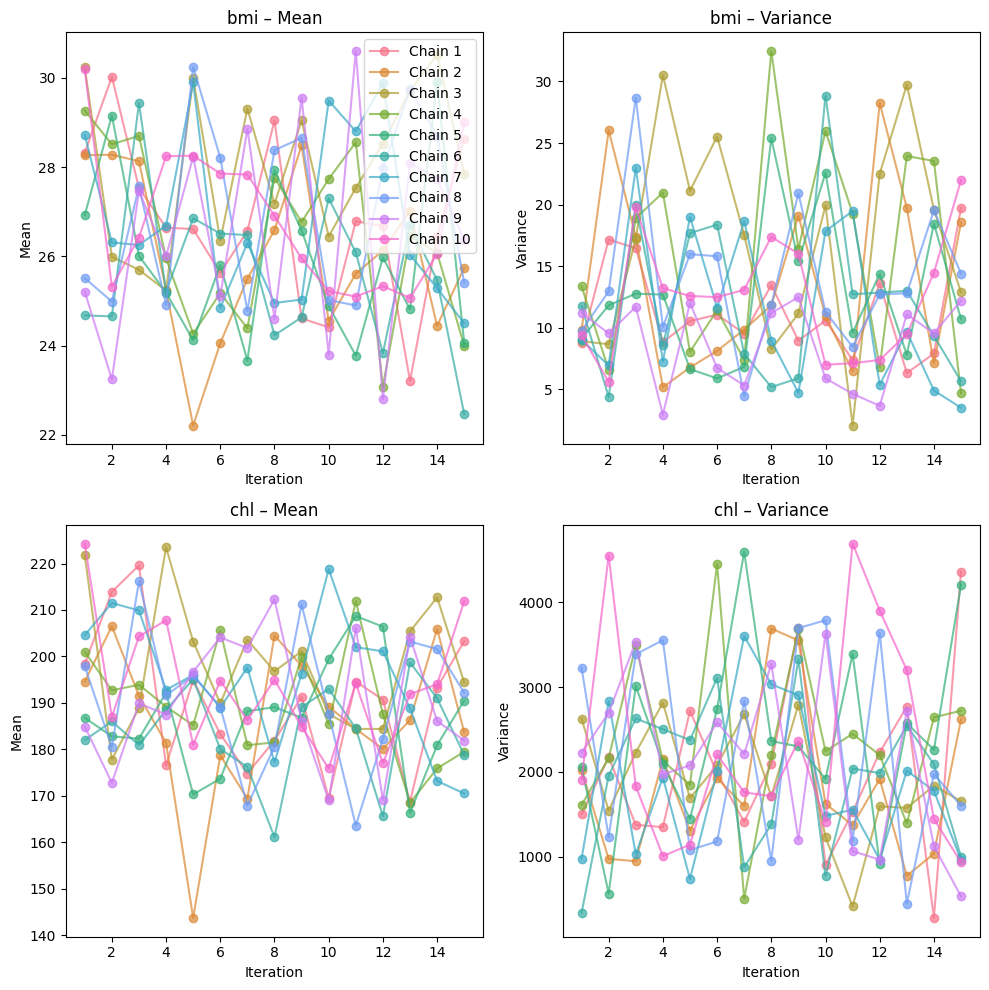

In [21]:
# Check convergence
plot_chain_stats(mice_comprehensive.chain_mean, mice_comprehensive.chain_var, columns=['bmi', 'chl'])


## Summary

In this notebook, we explored:
- **Method-specific parameters**: How to pass parameters like `pmm_donors`, `cart_max_depth`, etc.
- **Predictor matrix control**:
  - Auto-generated with `min_cor` and `min_puc` parameters
  - Custom predictor matrices
  - Include/exclude specific predictors
- **Imputation control**:
  - `n_imputations`: Number of complete datasets to create
  - `maxit`: Number of iterations per imputation
  - `visit_sequence`: Order of variable imputation
- **Initial imputation**: `sample` vs `meanobs` methods
- **Comprehensive example**: Combining multiple parameters

**Tips for parameter selection**:
- Start with defaults and adjust based on convergence diagnostics
- More imputations (≥10) for final analysis, fewer (5) for exploration
- Check convergence plots - if not stabilized, increase `maxit`
- Custom predictor matrices useful when domain knowledge suggests specific relationships

**Next steps**:
- See `04_analysis_workflow.ipynb` for fitting models and pooling results
- See `05_diagnostic_plots.ipynb` for comprehensive visual diagnostics
